# Test DECiSION

## Import packages

In [7]:
import DECiSION_settings as settings
from thesis_common import read_preprocess_image, read_preprocess_groundtruth,\
    convert_img_to_pred, convert_pred_to_img,\
    convert_img_to_pred_flatten, convert_pred_to_img_flatten, group_images, model_name_from_arguments

from dltoolkit.nn.segment import UNet_NN

import os, cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [12]:
TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_softmax_ep100.model"

## Load and preprocess data

In [3]:
# Load and preprocess the test and ground truth images (the latter will not be used during inference,
# only for visualisation)
if settings.IS_DEVELOPMENT:
    print("--- Pre-processing TRAINING images")
    test_imgs = read_preprocess_image("../data/MSC8002/training/train_imgs.h5", settings.HDF5_KEY)
    test_ground_truths = read_preprocess_groundtruth("../data/MSC8002/training/train_masks.h5", settings.HDF5_KEY)
else:
    print("--- Pre-processing test images")
    test_imgs = read_preprocess_image(
        os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES + settings.HDF5_EXT), settings.HDF5_KEY)


--- Pre-processing TRAINING images
Loading image HDF5: ../data/MSC8002/training/train_imgs.h5 with dtype = float32

Loading ground truth HDF5: ../data/MSC8002/training/train_masks.h5 with dtype = uint8



## Show an image as a test

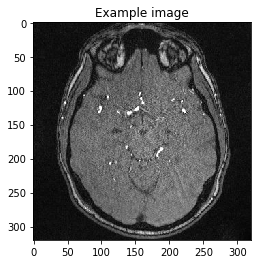

       Max image intensity: 0.7469630837440491 - float32 - (85, 320, 320, 1)


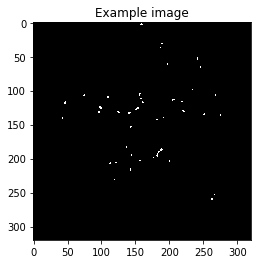

Max ground truth intensity: 255 - uint8 - (85, 320, 320, 1)


In [8]:
# Show an image plus its ground truth to check
IX = 0

plt.imshow(np.squeeze(test_imgs[IX]), cmap='gray')
plt.title('Example image')
plt.show()
print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[IX]), test_imgs.dtype, test_imgs.shape))
if settings.IS_DEVELOPMENT:
    plt.imshow(np.squeeze(test_ground_truths[IX]), cmap='gray')
    plt.title('Example ground truth')
    plt.show()
    print("Max ground truth intensity: {} - {} - {}".format(np.max(test_ground_truths[IX]), test_ground_truths.dtype, test_ground_truths.shape))

## Only predict for a few images

In [9]:
# Only predict for some images
PRED_IX = range(0, 16)
test_imgs = test_imgs[[PRED_IX]]
if settings.IS_DEVELOPMENT:
    test_ground_truths = test_ground_truths[[PRED_IX]]


## Load the trained model

In [17]:
# Create the UNet model and load its saved weights
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)
model = unet.build_model_softmax()
# model = unet.build_model_sigmoid()
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Make predictions

In [18]:
# Make predictions
print("\n--- Making predictions")
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)



--- Making predictions


## Convert predictions

In [19]:
# Convert predictions to images
predictions = convert_pred_to_img(predictions, settings, settings.TRN_PRED_THRESHOLD)
# print(" predictions.shape AFTER conv: {} ".format(predictions.shape))

## Show predictions

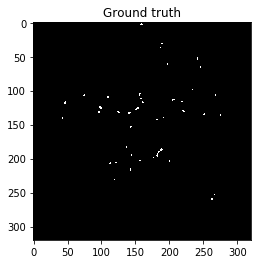

gr truth max 255 type uint8


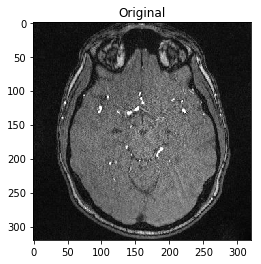

original 0.7469630837440491 type float32


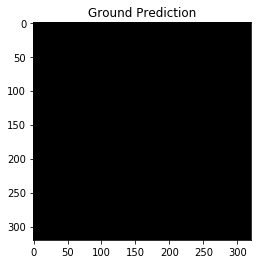

prediction 0 type uint8

--- Producing output images

--- Predicting complete


In [20]:
if settings.IS_DEVELOPMENT:
    tmp_img = test_ground_truths[0]
    plt.imshow(np.squeeze(tmp_img), cmap='gray')
    plt.title('Ground truth')
    plt.show()
    print("gr truth max {} type {}".format(np.max(tmp_img), tmp_img.dtype))

    tmp_img = test_imgs[0]
    plt.imshow(np.squeeze(tmp_img), cmap='gray')
    plt.title('Original')
    plt.show()
    print("original {} type {}".format(np.max(tmp_img), tmp_img.dtype))

    tmp_img = predictions[0]
    plt.imshow(np.squeeze(tmp_img), cmap='gray')
    plt.title('Prediction')
    plt.show()
    print("prediction {} type {}".format(np.max(tmp_img), tmp_img.dtype))

print("\n--- Producing output images")
if settings.IS_DEVELOPMENT:
    group_images(test_ground_truths[0:16], 4, 255, False, "../output/DECISION_"+unet.title+"_grp_originals")
group_images(test_imgs[0:16], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_images")
group_images(predictions[0:16], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_predictions")

print("\n--- Predicting complete")
